In [1]:
import numpy as np
from jesse import helpers, research

_, candles_ = research.get_candles(
    "Binance Perpetual Futures",
    "BTC-USDT",
    "1m",
    helpers.date_to_timestamp("2020-01-01"),
    helpers.date_to_timestamp("2025-05-20"),
    warmup_candles_num=0,
    caching=False,
    is_for_jesse=False,
)

print(candles_.shape)

np.save("data/btc_1m.npy", candles_)

(2831040, 6)


In [1]:
import numpy as np

candles_ = np.load("data/btc_1m.npy")
candles_ = candles_[candles_[:, 5] > 0]
print(candles_.shape)
candles_[0, 0]


(2830875, 6)


1577836800000.0

In [2]:
import os

import pandas as pd
from jesse.utils import numpy_candles_to_dataframe
from mpire import WorkerPool

from custom_indicators.toolbox.entropy.apen_sampen import sample_entropy_numba
from custom_indicators.utils.math_tools import log_ret

df = numpy_candles_to_dataframe(candles_)

# label
df["label"] = np.log(df["close"].shift(-1) / df["close"])

# high low range
df["hlr"] = np.log(df["high"] / df["low"])
# df["hlr_log"] = np.log(df["hlr"] + 1)
# df["hlr_sqrt"] = np.sqrt(df["hlr"] + 1) - 1

RANGE = [5, 10, 25, 50, 75, 100, 125, 150]

# abs return
ret_list = []
for i in RANGE:
    ret_series = np.log(df["close"] / df["close"].shift(i))
    ret_series.name = f"r{i}"
    ret_list.append(ret_series)

df = pd.concat([df, pd.concat(ret_list, axis=1)], axis=1)
del ret_list

# # log return
# log_list = []
# for i in RANGE:
#     log_series = np.log(df[f"r{i}"] + 1)
#     log_series.name = f"r{i}_log"
#     log_list.append(log_series)
#
# # sqrt return
# sqrt_list = []
# for i in RANGE:
#     sqrt_series = np.sqrt(df[f"r{i}"] + 1) - 1
#     sqrt_series.name = f"r{i}_sqrt"
#     sqrt_list.append(sqrt_series)

# entropy
entropy_list = []
for i in RANGE[2:]:
    log_ret_list = log_ret(candles_, [i] * len(candles_))
    with WorkerPool(n_jobs=os.cpu_count() - 1) as pool:
        entropy_array = pool.map(sample_entropy_numba, log_ret_list)
    len_gap = len(df) - len(entropy_array)
    entropy_array = [np.nan] * len_gap + entropy_array
    entropy_series = pd.Series(entropy_array, index=df.index)
    entropy_series.name = f"r{i}_entropy"
    entropy_list.append(entropy_series)

df = pd.concat(
    [
        df,
        # pd.concat(log_list, axis=1),
        # pd.concat(sqrt_list, axis=1),
        pd.concat(entropy_list, axis=1),
    ],
    axis=1,
)
del entropy_list


In [3]:
# data cleaning
na_max = df.isna().sum().max()
df = df.iloc[na_max:]
del candles_
print(df.shape)

print(df.isna().sum().max())
df.head()


(2830725, 22)
1


,date,open,close,high,low,volume,label,hlr,r5,r10,...,r75,r100,r125,r150,r25_entropy,r50_entropy,r75_entropy,r100_entropy,r125_entropy,r150_entropy
2020-01-01 02:30:00,2020-01-01 02:30:00,7221.59,7227.00,7227.79,7221.59,82.247,-0.000018,0.000858,0.000720,0.000969,...,0.005687,0.006817,0.007178,0.006185,0.200671,0.168884,0.090684,0.055175,0.044477,0.034509
2020-01-01 02:31:00,2020-01-01 02:31:00,7226.96,7226.87,7227.73,7223.93,118.737,-0.000143,0.000526,0.000567,0.000579,...,0.005671,0.006983,0.007284,0.006645,0.210721,0.172914,0.092568,0.057110,0.046081,0.035480
2020-01-01 02:32:00,2020-01-01 02:32:00,7226.06,7225.84,7226.13,7224.90,53.181,0.000195,0.000170,-0.000281,0.001112,...,0.005529,0.007356,0.007340,0.006652,0.270646,0.185109,0.094245,0.061849,0.049649,0.037777
2020-01-01 02:33:00,2020-01-01 02:33:00,7225.97,7227.25,7230.17,7224.78,100.884,0.000159,0.000746,-0.000199,0.000903,...,0.005724,0.007484,0.007681,0.006405,0.269920,0.193260,0.094383,0.061849,0.050010,0.038144
2020-01-01 02:34:00,2020-01-01 02:34:00,7226.88,7228.40,7228.44,7224.80,67.185,0.000112,0.000504,0.000955,0.000657,...,0.005655,0.007731,0.007783,0.007380,0.287682,0.168846,0.101039,0.063480,0.051519,0.039290


In [4]:
data_check = np.load("data/btc_1m.npy")
data_check = data_check[data_check[:, 5] > 0]
# hlr_check = np.abs(np.log(data_check[:, 3] / data_check[:, 4]))
# r1_check = np.abs(np.log(data_check[1:, 2] / data_check[:-1, 2]))

data_check = data_check[150:]
# hlr_check = hlr_check[149:]
# r1_check = r1_check[149 - 1 :]

# data_check = data_check[(hlr_check > 0) & (r1_check > 0)]

assert data_check.shape[0] == df.shape[0]

In [5]:
# from custom_indicators.utils.plot import find_kde_cross

# target = np.log(df["close"] / df["close"].shift(149)).dropna()
# roots = find_kde_cross(target)


In [6]:
# label = (df["abs_r1p149"] >= 1.026490246399058236).astype(int)
# label.name = "label"
# label.sort_index(inplace=True)
# label.value_counts()

In [5]:
import warnings

from gplearn.fitness import make_fitness
from gplearn.genetic import SymbolicRegressor
from scipy import stats

from custom_indicators.toolbox.bar.build import build_bar_by_cumsum


def gp_kurtosis(y, y_pred, w):
    warnings.filterwarnings("ignore", category=RuntimeWarning)

    if len(y_pred) <= 2:
        return 1000

    candles_in_metrics = np.load("data/btc_1m.npy")
    candles_in_metrics = candles_in_metrics[candles_in_metrics[:, 5] > 0]
    # h1r = np.abs(np.log(candles_in_metrics[:, 3] / candles_in_metrics[:, 4]))
    # r1 = np.abs(np.log(candles_in_metrics[1:, 2] / candles_in_metrics[:-1, 2]))
    candles_in_metrics = candles_in_metrics[150:]
    # h1r = h1r[149:]
    # r1 = r1[149 - 1 :]
    # candles_in_metrics = candles_in_metrics[(h1r > 0) & (r1 > 0)]
    candles_in_metrics = candles_in_metrics[:-1]

    assert len(candles_in_metrics) == len(y_pred), (
        f"{len(candles_in_metrics)} != {len(y_pred)}"
    )

    cumsum_threshold = np.sum(y_pred) / (len(candles_in_metrics) // 300)

    merged_bar_cumsum = build_bar_by_cumsum(
        candles_in_metrics,
        y_pred,
        cumsum_threshold,
        reverse=False,
    )
    log_ret_cumsum = np.log(merged_bar_cumsum[1:, 2] / merged_bar_cumsum[:-1, 2])
    std_log_ret_cumsum = (log_ret_cumsum - log_ret_cumsum.mean()) / log_ret_cumsum.std()
    kurtosis_cumsum = stats.kurtosis(std_log_ret_cumsum)

    if np.isnan(kurtosis_cumsum):
        return 1000
    return kurtosis_cumsum - 3


custom_kurtosis_loss = make_fitness(
    function=gp_kurtosis,
    greater_is_better=False,
    wrap=True,
)

cols = ["hlr"] + [f"r{i}" for i in RANGE] + [f"r{i}_entropy" for i in RANGE[2:]]

est_gp = SymbolicRegressor(
    init_method="full",
    metric=custom_kurtosis_loss,
    population_size=20000,
    generations=1,
    tournament_size=100,
    stopping_criteria=0,
    function_set=["add", "sub", "abs", "neg", "max", "min"],
    p_crossover=0.7,
    p_subtree_mutation=0.12,
    p_hoist_mutation=0.06,
    p_point_mutation=0.12,
    max_samples=1,
    parsimony_coefficient=0.01,
    feature_names=cols,
    verbose=1,
    n_jobs=10,
    # random_state=233,
)

label = df["label"]

est_gp.fit(df[cols].iloc[:-1], label.iloc[:-1])

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    23.08          179.493       50        -0.137535              N/A      0.00s


SymbolicRegressor(feature_names=['hlr', 'r5', 'r10', 'r25', 'r50', 'r75',
                                 'r100', 'r125', 'r150', 'r25_entropy',
                                 'r50_entropy', 'r75_entropy', 'r100_entropy',
                                 'r125_entropy', 'r150_entropy'],
                  function_set=['add', 'sub', 'abs', 'neg', 'max', 'min'],
                  generations=1, init_method='full', max_samples=1,
                  metric=<gplearn.fitness._Fitness object at 0x138be4f50>,
                  n_jobs=10, p_crossover=0.7, p_hoist_mutation=0.06,
                  p_point_mutation=0.12, p_subtree_mutation=0.12,
                  parsimony_coefficient=0.01, population_size=20000,
                  stopping_criteria=0, tournament_size=100, verbose=1)

In [6]:
import pandas as pd

fitness_list = []
program_len_list = []
program_list = []

for lst in est_gp._programs:
    for program in lst:
        if program and program.fitness_ < 2:
            fitness_list.append(program.fitness_)
            program_len_list.append(len(str(program)))
            program_list.append(str(program))

df_res = pd.DataFrame(
    {"fitness": fitness_list, "len": program_len_list, "program": program_list}
).drop_duplicates(subset=["program"])
df_res.sort_values(by=["len", "fitness"], inplace=True)
df_res


,fitness,len,program
9,1.273428,18,"abs(sub(r50, hlr))"
55,1.836437,18,"abs(add(r10, r75))"
51,1.697467,22,"add(abs(r10), neg(r5))"
70,1.151560,23,"abs(neg(sub(hlr, r25)))"
20,1.283428,23,"abs(neg(sub(hlr, r50)))"
...,...,...,...
44,1.570960,235,"min(neg(min(neg(add(r25_entropy, r75)), max(mi..."
17,1.028480,251,"abs(min(max(add(neg(neg(r50)), min(neg(r5), mi..."
76,1.697364,301,"min(abs(neg(abs(min(add(r50, r25), max(r150, r..."
15,0.362465,309,"min(min(min(min(max(r150_entropy, r50), neg(-0..."


In [11]:
df_res[df_res["fitness"] < 2].sort_values("fitness")

,fitness,len,program
51,0.727899,90,"min(add(max(r75_entropy, r5), max(r5, r75_entr..."
21,0.784953,93,"min(max(neg(r100_entropy), abs(r25)), add(min(..."
36,0.843171,95,"abs(min(max(max(r100, r125), abs(r100_entropy)..."
27,0.888029,208,"abs(max(min(abs(min(abs(r10), sub(0.511, r5)))..."
40,0.986920,302,"max(max(min(neg(add(r100_entropy, r5)), sub(ad..."
49,1.118329,42,"abs(min(abs(r100), min(r50, r25_entropy)))"
18,1.141560,18,"abs(sub(hlr, r25))"
33,1.141560,18,"abs(sub(r25, hlr))"
46,1.162753,120,"max(add(sub(abs(r75), add(r75, r75_entropy)), ..."
56,1.206938,133,"min(add(add(add(r150, r125), min(r75_entropy, ..."


In [7]:
for fitness, program in zip(df_res["fitness"], df_res["program"]):
    print(f"{fitness = }: {program}")


fitness = 1.2734278343506258: abs(sub(r50, hlr))
fitness = 1.836436705154032: abs(add(r10, r75))
fitness = 1.6974665983714232: add(abs(r10), neg(r5))
fitness = 1.151559779277796: abs(neg(sub(hlr, r25)))
fitness = 1.2834278343506258: abs(neg(sub(hlr, r50)))
fitness = 1.6273422124232584: max(abs(r10), abs(r50))
fitness = 1.753782177273582: max(abs(r10), abs(hlr))
fitness = 1.4689441239599337: max(abs(r50), abs(r100))
fitness = 1.3317632304250018: add(abs(r10), sub(r5, r10))
fitness = 1.596622555531936: abs(min(hlr, r125_entropy))
fitness = 1.596622555531936: abs(min(r125_entropy, hlr))
fitness = 1.2624380740131314: min(abs(r50), abs(r50_entropy))
fitness = 1.5570092175780925: min(abs(r75_entropy), abs(r10))
fitness = 0.9559704549716153: min(abs(r75), add(r5, r75_entropy))
fitness = 1.2960196205364294: abs(max(abs(r150), min(r75, r100)))
fitness = 1.3567226559379582: min(max(r50_entropy, r10), abs(r50))
fitness = 1.5564251304691674: min(abs(r25), add(r25_entropy, r10))
fitness = 1.7301302

In [1]:
"""
min(abs(r25), add(r100, r50_entropy))
min(abs(r50), max(r75_entropy, r100_entropy))
abs(min(max(r100, r25_entropy), abs(r10)))
min(abs(r25), max(r10, r100_entropy))
min(abs(r75), add(r5, r75_entropy))
"""
import os

import numpy as np
from jesse import helpers, research
from jesse.utils import numpy_candles_to_dataframe
from mpire import WorkerPool

from custom_indicators.toolbox.bar.entropy_bar_v2 import sample_entropy_numba
from custom_indicators.utils.math_tools import log_ret

_, candles_ = research.get_candles(
    "Binance Perpetual Futures",
    "BTC-USDT",
    "1m",
    helpers.date_to_timestamp("2020-01-01"),
    helpers.date_to_timestamp("2025-05-20"),
    warmup_candles_num=0,
    caching=False,
    is_for_jesse=False,
)
candles_ = candles_[candles_[:, 5] > 0]

print(candles_.shape)

# hlr_check = np.abs(np.log(candles[:, 3] / candles[:, 4]))[1:]
# r1_check = np.abs(np.log(candles[1:, 2] / candles[:-1, 2]))
# candles = candles[1:]

# candles = candles[(hlr_check > 0) & (r1_check > 0)]

df = numpy_candles_to_dataframe(candles_)
df["r25"] = np.log(df["close"] / df["close"].shift(25))
df["r100"] = np.log(df["close"] / df["close"].shift(100))
log_ret_list = log_ret(candles_, [50] * len(candles_))
with WorkerPool(n_jobs=os.cpu_count() - 1) as pool:
    entropy_array = pool.map(sample_entropy_numba, log_ret_list)
len_gap = len(df) - len(entropy_array)
entropy_array = [np.nan] * len_gap + entropy_array
df["r50_entropy"] = entropy_array

df["threshold"] = [
    min(x, y)
    for x, y in zip(
        np.abs(df["r25"]).tolist(), (df["r100"] + df["r50_entropy"]).tolist()
    )
]

na_max = df.isna().sum().max()
df = df.iloc[na_max:]
print(df.shape)
df.head()

(2830875, 6)
(2830775, 10)


,date,open,close,high,low,volume,r25,r100,r50_entropy,threshold
2020-01-01 01:40:00,2020-01-01 01:40:00,7210.51,7213.42,7213.42,7210.29,31.414,0.003806,0.004304,0.109267,0.003806
2020-01-01 01:41:00,2020-01-01 01:41:00,7213.42,7208.45,7213.42,7206.66,68.876,0.003119,0.004092,0.099699,0.003119
2020-01-01 01:42:00,2020-01-01 01:42:00,7209.08,7207.14,7209.08,7206.00,27.482,0.002938,0.004061,0.102452,0.002938
2020-01-01 01:43:00,2020-01-01 01:43:00,7207.14,7206.82,7208.97,7201.04,116.250,0.002893,0.003574,0.100486,0.002893
2020-01-01 01:44:00,2020-01-01 01:44:00,7207.05,7206.63,7208.12,7206.40,8.715,0.002639,0.004364,0.106005,0.002639


In [2]:
df["threshold"].sum() / (len(candles_) // 300)

0.7907317146647048

In [3]:
df.tail()

,date,open,close,high,low,volume,r25,r100,r50_entropy,threshold
2025-05-19 23:55:00,2025-05-19 23:55:00,105568.2,105560.1,105583.4,105554.7,23.323,0.001098,0.002268,0.192815,0.001098
2025-05-19 23:56:00,2025-05-19 23:56:00,105560.1,105534.3,105568.3,105534.3,19.583,0.000859,0.003312,0.199333,0.000859
2025-05-19 23:57:00,2025-05-19 23:57:00,105534.3,105536.3,105536.3,105514.7,30.142,0.000507,0.002750,0.203535,0.000507
2025-05-19 23:58:00,2025-05-19 23:58:00,105536.2,105536.3,105540.0,105536.2,19.197,0.000539,0.002525,0.188447,0.000539
2025-05-19 23:59:00,2025-05-19 23:59:00,105536.3,105531.6,105547.5,105531.2,40.601,0.000348,0.002987,0.194672,0.000348


In [4]:
len(candles_) - len(df)

100

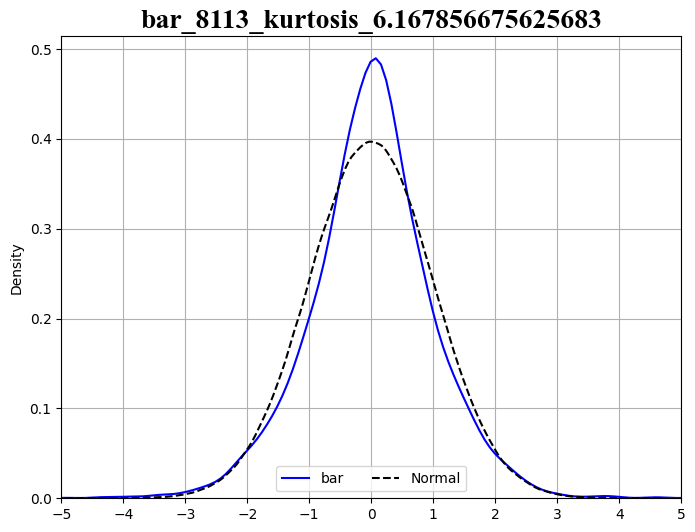

In [5]:
from custom_indicators.utils.plot import plot_kde

assert len(candles_[100:]) == len(df)

"""
threshold:
0.7907317146647048
0.916133494307828
"""

merged_bar = build_bar_by_cumsum(
    candles_[100:], df["threshold"].tolist(), 0.916133494307828, reverse=False
)

plot_kde(merged_bar[:, 2])

In [12]:
import optuna


def objective(trial: optuna.Trial) -> float:
    merge_threshold = trial.suggest_float("merge_threshold", 0.0, 1.0)
    merged_bar = build_bar_by_cumsum(
        candles_[100:], df["threshold"].tolist(), merge_threshold, reverse=False
    )
    close_arr = merged_bar[:, 2]
    ret = np.log(close_arr[1:] / close_arr[:-1])
    standard = (ret - ret.mean()) / ret.std()
    kurtosis = stats.kurtosis(standard, axis=None, fisher=False, nan_policy="omit")
    return kurtosis


study = optuna.create_study(
    direction="minimize",
    pruner=optuna.pruners.HyperbandPruner(),
    sampler=optuna.samplers.TPESampler(),
)
study.optimize(objective, n_trials=100, n_jobs=1)

[I 2025-05-28 23:14:00,303] A new study created in memory with name: no-name-dfa419a5-b5a6-4654-8aef-f2f114d76ffd
[I 2025-05-28 23:14:01,141] Trial 0 finished with value: 10.76020536158673 and parameters: {'merge_threshold': 0.24989561766212098}. Best is trial 0 with value: 10.76020536158673.
[I 2025-05-28 23:14:01,962] Trial 1 finished with value: 7.376626751414728 and parameters: {'merge_threshold': 0.8691228226638732}. Best is trial 1 with value: 7.376626751414728.
[I 2025-05-28 23:14:02,793] Trial 2 finished with value: 6.432706193986712 and parameters: {'merge_threshold': 0.8693532922621539}. Best is trial 2 with value: 6.432706193986712.
[I 2025-05-28 23:14:03,616] Trial 3 finished with value: 8.184323663048705 and parameters: {'merge_threshold': 0.46628600674323484}. Best is trial 2 with value: 6.432706193986712.
[I 2025-05-28 23:14:04,435] Trial 4 finished with value: 8.385452438540868 and parameters: {'merge_threshold': 0.7768783056852469}. Best is trial 2 with value: 6.432706

In [13]:
study.best_params

{'merge_threshold': 0.916133494307828}

In [14]:
import optuna

# 尝试进一步迭代


def objective(trial: optuna.Trial) -> float:
    candles = np.load("data/btc_1m.npy")
    candles = candles[candles[:, 5] > 0]
    df = numpy_candles_to_dataframe(candles)
    # short log ret
    short_log_n = trial.suggest_int("short_log_n", 5, 50)
    df[f"r{short_log_n}"] = np.log(df["close"] / df["close"].shift(short_log_n))

    # long log ret
    long_log_n = trial.suggest_int("long_log_n", 51, 200)
    df[f"r{long_log_n}"] = np.log(df["close"] / df["close"].shift(long_log_n))

    # entropy
    entropy_n = trial.suggest_int("entropy_n", 30, 100)
    log_ret_list = log_ret(candles, [entropy_n] * len(candles))
    with WorkerPool(n_jobs=os.cpu_count() - 1) as pool:
        entropy_array = pool.map(sample_entropy_numba, log_ret_list)
    len_gap = len(df) - len(entropy_array)
    entropy_array = [np.nan] * len_gap + entropy_array
    df[f"en_{entropy_n}"] = entropy_array

    na_max = df.isna().sum().max()
    df = df.iloc[na_max:]

    df["threshold"] = [
        min(x, y)
        for x, y in zip(
            np.abs(df[f"r{short_log_n}"]).tolist(),
            (df[f"r{long_log_n}"] + df[f"en_{entropy_n}"]).tolist(),
        )
    ]

    threshold_min = df["threshold"].sum() / (len(candles) // 60)
    threshold_max = df["threshold"].sum() / (len(candles) // 360)
    threshold = trial.suggest_float("threshold", threshold_min, threshold_max)

    len_gap = len(candles) - len(df)
    candles = candles[len_gap:]
    assert len(candles) == len(df), f"{len(candles)} != {len(df)}"
    merged_bar = build_bar_by_cumsum(
        candles, df["threshold"].tolist(), threshold, reverse=False
    )
    close_arr = merged_bar[:, 2]
    ret = np.log(close_arr[1:] / close_arr[:-1])
    standard = (ret - ret.mean()) / ret.std()
    kurtosis = stats.kurtosis(standard, axis=None, fisher=False, nan_policy="omit")
    return kurtosis


study = optuna.create_study(
    direction="minimize",
    pruner=optuna.pruners.NopPruner(),
    sampler=optuna.samplers.TPESampler(n_startup_trials=100),
)
study.optimize(objective, n_trials=1000, n_jobs=1, gc_after_trial=True)

[I 2025-05-29 09:21:36,434] A new study created in memory with name: no-name-4e7b16ba-e8a1-479a-b42a-a5432287c82c
[I 2025-05-29 09:21:38,421] Trial 0 finished with value: 9.03863290413417 and parameters: {'short_log_n': 11, 'long_log_n': 191, 'threshold': 0.2242738715325297}. Best is trial 0 with value: 9.03863290413417.
[I 2025-05-29 09:21:40,348] Trial 1 finished with value: 14.876121824915503 and parameters: {'short_log_n': 42, 'long_log_n': 84, 'threshold': 0.5169881685757164}. Best is trial 0 with value: 9.03863290413417.
[I 2025-05-29 09:21:42,347] Trial 2 finished with value: 9.798656726972247 and parameters: {'short_log_n': 16, 'long_log_n': 167, 'threshold': 0.22201988372335763}. Best is trial 0 with value: 9.03863290413417.
[I 2025-05-29 09:21:44,359] Trial 3 finished with value: 12.510165065876386 and parameters: {'short_log_n': 44, 'long_log_n': 160, 'threshold': 0.5712850899450568}. Best is trial 0 with value: 9.03863290413417.
[I 2025-05-29 09:21:46,340] Trial 4 finished 

In [15]:
study.best_params

{'short_log_n': 14, 'long_log_n': 197, 'threshold': 0.5517990079848106}

In [4]:
import numpy as np
import optuna

from custom_indicators.toolbox.bar.fusion.v1 import FusionBarContainerV1


def objective(trial: optuna.Trial) -> float:
    candles = np.load("data/btc_1m.npy")
    candles = candles[candles[:, 5] > 0]
    bar_container = FusionBarContainerV1()
    bar_container.SHORT_N = trial.suggest_int("short_log_n", 1, 100)
    bar_container.LONG_N = trial.suggest_int(
        "long_log_n", max(bar_container.SHORT_N + 1, 30), 300
    )
    bar_container.ENTROPY_N = trial.suggest_int(
        "rn_entropy", 25, bar_container.LONG_N - 1
    )
    bar_container.THRESHOLD = trial.suggest_float("threshold", 0.0, 1.0)
    bar_container.update_with_candles(candles)
    merged_bar = bar_container.get_fusion_bars()
    if len(merged_bar) < len(candles) // 300:
        return 1000
    return stats.kurtosis(merged_bar[:, 2], axis=None, fisher=False, nan_policy="omit")


study = optuna.create_study(
    direction="minimize",
    pruner=optuna.pruners.NopPruner(),
    sampler=optuna.samplers.TPESampler(n_startup_trials=100),
)
study.optimize(objective, n_trials=1000, n_jobs=1, gc_after_trial=True)

[I 2025-06-01 00:33:10,354] A new study created in memory with name: no-name-a9b595fb-d034-4ebe-805e-aa2777d531e3
[I 2025-06-01 00:34:09,547] Trial 0 finished with value: 1000.0 and parameters: {'short_log_n': 23, 'long_log_n': 232, 'rn_entropy': 67, 'threshold': 0.9706500801237098}. Best is trial 0 with value: 1000.0.
[I 2025-06-01 00:34:56,409] Trial 1 finished with value: 3.0191094404703516 and parameters: {'short_log_n': 10, 'long_log_n': 196, 'rn_entropy': 45, 'threshold': 0.17622908392528447}. Best is trial 1 with value: 3.0191094404703516.
[I 2025-06-01 00:36:06,891] Trial 2 finished with value: 2.8930195789290565 and parameters: {'short_log_n': 64, 'long_log_n': 295, 'rn_entropy': 221, 'threshold': 0.7487661209398284}. Best is trial 2 with value: 2.8930195789290565.
[I 2025-06-01 00:36:53,093] Trial 3 finished with value: 3.03228432155669 and parameters: {'short_log_n': 29, 'long_log_n': 187, 'rn_entropy': 45, 'threshold': 0.6037140855938129}. Best is trial 2 with value: 2.8930

KeyboardInterrupt: 

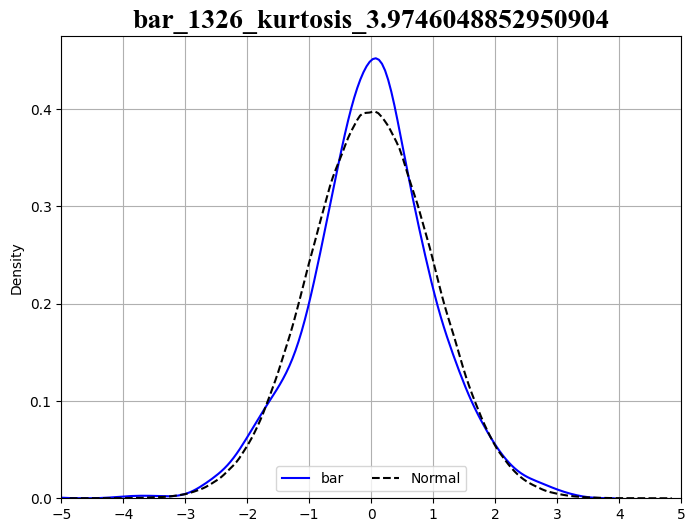

In [ ]:
from jesse import helpers, research

from custom_indicators.utils.plot import plot_kde

"""
SHORT_N = 21
LONG_N = 180
ENTROPY_N = 34
THRESHOLD = 0.8548507667918396
"""

_, candles = research.get_candles(
    "Binance Perpetual Futures",
    "BTC-USDT",
    "1m",
    helpers.date_to_timestamp("2024-01-01"),
    helpers.date_to_timestamp("2025-01-01"),
    warmup_candles_num=0,
    caching=False,
    is_for_jesse=False,
)

bar_container = FusionBarContainerV1()
bar_container.SHORT_N = 21
bar_container.LONG_N = 180
bar_container.ENTROPY_N = 34
bar_container.THRESHOLD = 0.8548507667918396
bar_container.update_with_candles(candles)
merged_bar = bar_container.get_fusion_bars()

plot_kde(merged_bar[:, 2])

In [ ]:
"""
min(abs(short_log_n), add(long_log_n, rn_entropy))
{'short_log_n': 21,
 'long_log_n': 180,
 'rn_entropy': 34,
 'threshold': 0.8548507667918396}

 
"""

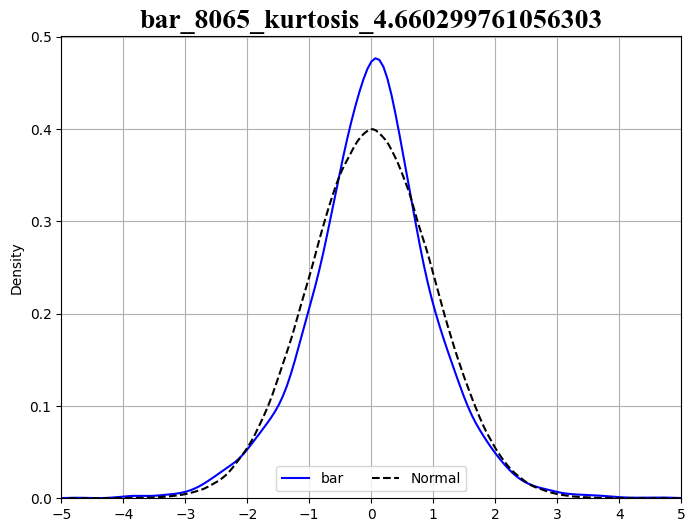

In [24]:
import os

import numpy as np
from jesse import helpers, research
from jesse.utils import numpy_candles_to_dataframe
from mpire import WorkerPool

from custom_indicators.toolbox.bar.build import build_bar_by_cumsum
from custom_indicators.toolbox.bar.entropy_bar_v2 import sample_entropy_numba
from custom_indicators.utils.math_tools import log_ret

_, candles = research.get_candles(
    "Binance Perpetual Futures",
    "BTC-USDT",
    "1m",
    helpers.date_to_timestamp("2020-01-01"),
    helpers.date_to_timestamp("2025-05-31"),
    warmup_candles_num=0,
    caching=False,
    is_for_jesse=False,
)
print(candles.shape)
candles = candles[candles[:, 5] > 0]
df = numpy_candles_to_dataframe(candles)
# short log ret
short_log_n = 21
df[f"r{short_log_n}"] = np.log(df["close"] / df["close"].shift(short_log_n))

# long log ret
long_log_n = 180
df[f"r{long_log_n}"] = np.log(df["close"] / df["close"].shift(long_log_n))

# entropy
entropy_n = 34
log_ret_list = log_ret(candles_, entropy_n)
with WorkerPool(n_jobs=os.cpu_count() - 1) as pool:
    entropy_array = pool.map(sample_entropy_numba, log_ret_list)
len_gap = len(df) - len(entropy_array)
entropy_array = [np.nan] * len_gap + entropy_array
df[f"en_{entropy_n}"] = entropy_array

na_max = df.isna().sum().max()
df = df.iloc[na_max:]

df["threshold"] = [
    min(x, y)
    for x, y in zip(
        np.abs(df[f"r{short_log_n}"]).tolist(),
        (df[f"r{long_log_n}"] + df[f"en_{entropy_n}"]).tolist(),
    )
]

threshold = 0.8548507667918396

len_gap = len(candles) - len(df)
candles = candles[len_gap:]
assert len(candles) == len(df), f"{len(candles)} != {len(df)}"
merged_bar = build_bar_by_cumsum(
    candles, df["threshold"].tolist(), threshold, reverse=False
)

from custom_indicators.utils.plot import plot_kde

plot_kde(merged_bar[:, 2])

In [ ]:
bar_container = FusionBarContainerV1()
thresholds = bar_container._get_thresholds(candles)

In [31]:
len(candles) - len(df)

0

In [26]:
df["threshold"]

2020-01-01 03:34:00    0.002127
2020-01-01 03:35:00    0.001942
2020-01-01 03:36:00    0.000540
2020-01-01 03:37:00    0.000082
2020-01-01 03:38:00    0.001046
                         ...   
2025-05-30 23:55:00    0.002473
2025-05-30 23:56:00    0.003039
2025-05-30 23:57:00    0.000402
2025-05-30 23:58:00    0.001216
2025-05-30 23:59:00    0.002361
Name: threshold, Length: 2846501, dtype: float64

In [37]:
(df["threshold"].iloc[180:] - thresholds).sum()

0.0

In [18]:
df["close"]

2020-01-01 03:34:00      7238.46
2020-01-01 03:35:00      7236.59
2020-01-01 03:36:00      7227.47
2020-01-01 03:37:00      7224.86
2020-01-01 03:38:00      7222.34
                         ...    
2025-05-30 23:55:00    103999.00
2025-05-30 23:56:00    103992.60
2025-05-30 23:57:00    103915.90
2025-05-30 23:58:00    103932.90
2025-05-30 23:59:00    103950.00
Name: close, Length: 2846501, dtype: float64

In [17]:
df["r21"]

2020-01-01 03:34:00    0.002127
2020-01-01 03:35:00    0.001942
2020-01-01 03:36:00    0.000540
2020-01-01 03:37:00    0.000082
2020-01-01 03:38:00   -0.001046
                         ...   
2025-05-30 23:55:00    0.002473
2025-05-30 23:56:00    0.003039
2025-05-30 23:57:00    0.000402
2025-05-30 23:58:00    0.001216
2025-05-30 23:59:00    0.002361
Name: r21, Length: 2846501, dtype: float64

In [16]:
log_ret_short_n = np.log(candles[21:, 2] / candles[:-21, 2])[180 - 21 :]
log_ret_short_n[0]

6.228567673667354e-05

In [1]:
import numpy as np
from jesse import helpers, research

candles = np.load("data/btc_1m.npy")
candles.shape

(2831040, 6)

In [2]:
from mpire import WorkerPool

from custom_indicators.toolbox.bar.build import build_bar_by_cumsum
from custom_indicators.toolbox.entropy.apen_sampen import sample_entropy_numba
from custom_indicators.utils.math_tools import log_ret

SHORT_N = 21
LONG_N = 180
ENTROPY_N = 34
THRESHOLD = 0.8548507667918396

_unfinished_bars_timestamps = None
_unfinished_bars_thresholds = None
_merged_bars = None


def get_thresholds(candles_: np.ndarray) -> np.ndarray:
    log_ret_short_n = np.log(candles_[SHORT_N:, 2] / candles_[:-SHORT_N, 2])[
        LONG_N - SHORT_N :
    ]

    log_ret_long_n = np.log(candles_[LONG_N:, 2] / candles_[:-LONG_N, 2])
    entropy_log_ret_list = log_ret(candles_[LONG_N - ENTROPY_N :, :], ENTROPY_N)
    with WorkerPool() as pool:
        entropy_array = pool.map(sample_entropy_numba, entropy_log_ret_list)
    del entropy_log_ret_list

    return np.min([np.abs(log_ret_short_n), log_ret_long_n + entropy_array], axis=0)


# 初始化
init_candles = candles[candles[:, 5] > 0][:-10000]
thresholds = get_thresholds(init_candles)
init_candles = init_candles[len(init_candles) - len(thresholds) :]
_merged_bars = build_bar_by_cumsum(candles, thresholds, THRESHOLD, reverse=False)

_unfinished_bars_timestamps = init_candles[:, 0].astype(int)[
    init_candles[:, 0].astype(int) > _merged_bars[-1, 0].astype(int)
]
_unfinished_bars_thresholds = thresholds[
    init_candles[:, 0].astype(int) > _merged_bars[-1, 0].astype(int)
]

In [7]:
update_candles = candles[:-9999]
anchor_index_array = np.where(
    candles[:, 0].astype(int) > _merged_bars[-1, 0].astype(int)
)[0]
anchor_index = anchor_index_array[0] - LONG_N
update_candles = update_candles[anchor_index:]
update_thresholds = get_thresholds(update_candles)
all_thresholds = np.hstack([_unfinished_bars_thresholds, update_thresholds])
len(all_thresholds)

1423

In [10]:
all_unfinished_candles = candles[:-9999][
    candles[:-9999][:, 0].astype(int) > _unfinished_bars_timestamps[0]
]
all_unfinished_candles.shape

(711, 6)